# Total Cost Prediction
This notebook explores the [Hospital Inpatient Discharges](https://health.data.ny.gov/Health/Hospital-Inpatient-Discharges-SPARCS-De-Identified/82xm-y6g8) dataset, attempting to predict the total estimated cost of care. This dataset is de-identified, meaning no identifiable information is included and it can be used for public projects. These observations were taken from the discharge year 2015 in the state of New York and were released by the New York State Department of Health. 

This data was downloaded on February 13th, 2020 and totaled around 900Mb on disk.

In [70]:
# imports
import numpy as np
import pandas as pd

from scipy.stats import f_oneway, chi2_contingency

import matplotlib.pyplot as plt

# show all jupyter notebook output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error, mean_absolute_error

import xgboost

In [64]:
# h2o imports
import h2o
h2o.init(nthreads=3, max_mem_size="13g")
from h2o.sklearn import H2OAutoMLRegressor
from h2o.automl import H2OAutoML

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.111-b14, mixed mode)
  Starting server from C:\Users\tstuesssi\Anaconda3\envs\empiric\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\TSTUES~1\AppData\Local\Temp\tmpvk6gibsq
  JVM stdout: C:\Users\TSTUES~1\AppData\Local\Temp\tmpvk6gibsq\h2o_tstuesssi_started_from_python.out
  JVM stderr: C:\Users\TSTUES~1\AppData\Local\Temp\tmpvk6gibsq\h2o_tstuesssi_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.4
H2O_cluster_version_age:,"14 days, 6 hours and 41 minutes"
H2O_cluster_name:,H2O_from_python_tstuesssi_zpvar8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,11.56 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"accepting new members, healthy"


## Cleaning
Before we dive into modeling, let's take some time to clean up the data set. First, we will load up the dataset into a pandas dataframe and run some basic summary statistics.

In [5]:
datapath = "data/Hospital_Inpatient_Discharges__SPARCS_De-Identified___2015.csv"
full_dataset = pd.read_csv(datapath)
full_dataset.shape
full_dataset.columns
full_dataset.head()

C:\Users\tstuesssi\Anaconda3\envs\empiric\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(2346931, 34)

Index(['Health Service Area', 'Hospital County',
       'Operating Certificate Number', 'Facility Id', 'Facility Name',
       'Age Group', 'Zip Code - 3 digits', 'Gender', 'Race', 'Ethnicity',
       'Length of Stay', 'Type of Admission', 'Patient Disposition',
       'Discharge Year', 'CCS Diagnosis Code', 'CCS Diagnosis Description',
       'CCS Procedure Code', 'CCS Procedure Description', 'APR DRG Code',
       'APR DRG Description', 'APR MDC Code', 'APR MDC Description',
       'APR Severity of Illness Code', 'APR Severity of Illness Description',
       'APR Risk of Mortality', 'APR Medical Surgical Description',
       'Payment Typology 1', 'Payment Typology 2', 'Payment Typology 3',
       'Birth Weight', 'Abortion Edit Indicator',
       'Emergency Department Indicator', 'Total Charges', 'Total Costs'],
      dtype='object')

,Health Service Area,Hospital County,Operating Certificate Number,Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs
0,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,Minor,Medical,Medicare,Private Health Insurance,NaN,0,N,Y,5333.90,4818.42
1,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,Moderate,Medical,Medicare,NaN,NaN,0,N,Y,4865.99,4588.78
2,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,Minor,Medical,Medicare,Private Health Insurance,NaN,0,N,Y,5901.54,5559.56
3,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,50 to 69,147,F,White,Not Span/Hispanic,...,Minor,Medical,Medicare,NaN,NaN,0,N,Y,3619.08,3567.25
4,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,M,White,Not Span/Hispanic,...,Moderate,Medical,Medicare,Blue Cross/Blue Shield,Private Health Insurance,0,N,Y,3185.87,3167.89


2.3 million rows is quite a lot - that might cause some performance issues down the road. However, this tidbit gives us quite a bit of information up front, including the column names. The "Total Costs" column is the one we are predicting, with most of the rest being our feature columns. We can throw out a few columns immediately:
 * Description columns - we will print the shorter ones for reference, but these won't add any value:
  * Facility ID (we will use name for interpretability later on)
  * Operating Certificate Number (proxy for facility ID according to the data description)
  * CCS Diagnosis Description
  * CCS Procedure Description
  * APR DRG Description
  * APR MDC Description
  * APR Severity of Illness Description
 * Abortion edit indicator - we will use this column for another purpose later on, so I won't be dropping it just yet but will later on.
 * Discharge Year - all 2015
 * Total Charges - it was unclear in the documentation how this relates to Total Costs, so I'm assuming it's a proxy and throwing it out


First, let's validate that last assumption:

Pearson Correlation


,Total Charges,Total Costs
Total Charges,1.00000,0.90176
Total Costs,0.90176,1.00000


<AxesSubplot:xlabel='Total Costs', ylabel='Total Charges'>

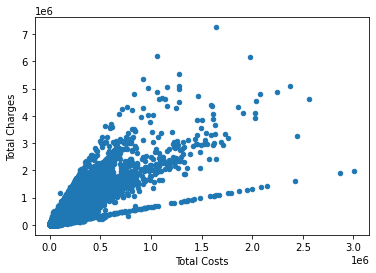

In [6]:
print("Pearson Correlation")
full_dataset[["Total Charges", "Total Costs"]].corr()
full_dataset.plot(kind="scatter", x="Total Costs", y="Total Charges")

In [7]:
full_dataset["Discharge Year"].value_counts()

2015    2346931
Name: Discharge Year, dtype: int64

Like I said, they seemed to be proxies of each other. I feel that we can safely throw out this variable. The other descriptor variables are listed in the "Codes Reference" notebook.

In [8]:
# drop the variables
dropped_cols = ["Facility Id", "Operating Certificate Number", "CCS Diagnosis Description", "CCS Procedure Description",
                "APR DRG Description", "APR MDC Description", "APR Severity of Illness Description", "Discharge Year",
                "Total Charges"]
trimmed_dataset = full_dataset.drop(dropped_cols, axis=1)

Next, we need to define the data types of our predictor variables - mainly expressly turning categorical variables into categories. This will help in performance later on. We will start with the obvious ones:

In [9]:
category_list = [
    "Health Service Area",
    "Hospital County",
    "Facility Name",
    "Age Group",
    "Zip Code - 3 digits",
    "Gender",
    "Race", 
    "Ethnicity",
    "Type of Admission",
    "Patient Disposition",
    "CCS Diagnosis Code",
    "CCS Procedure Code",
    "APR DRG Code",
    "APR MDC Code",
    "APR Severity of Illness Code",
    "APR Risk of Mortality",
    "APR Medical Surgical Description",
    "Payment Typology 1",
    "Payment Typology 2",
    "Payment Typology 3",
    "Emergency Department Indicator"
]

category_map = {cat: "category" for cat in category_list}
trimmed_dataset = trimmed_dataset.astype(category_map)

Length of stay should be numerical, but if a stay is greater than 120 days then it is truncated to 120 +. Given the unlikely nature of that, it's fine to just force that to be 120.

In [10]:
trimmed_dataset["Length of Stay"] = trimmed_dataset["Length of Stay"].apply(lambda x: 120 if x == "120 +" else int(x)).astype("int32")

In [11]:
# fill some NAs
trimmed_dataset.isna().sum(axis=0)

Health Service Area                    5464
Hospital County                        5464
Facility Name                             0
Age Group                                 0
Zip Code - 3 digits                   35816
Gender                                    0
Race                                      0
Ethnicity                                 0
Length of Stay                            0
Type of Admission                         0
Patient Disposition                       0
CCS Diagnosis Code                        0
CCS Procedure Code                        0
APR DRG Code                              0
APR MDC Code                              0
APR Severity of Illness Code              0
APR Risk of Mortality                   111
APR Medical Surgical Description          0
Payment Typology 1                        0
Payment Typology 2                   762285
Payment Typology 3                  1645513
Birth Weight                              0
Abortion Edit Indicator         

In [12]:
# only filling a few of these - you will see why later
trimmed_dataset["APR Risk of Mortality"].cat.add_categories("None", inplace=True)
trimmed_dataset["APR Risk of Mortality"] = trimmed_dataset["APR Risk of Mortality"].fillna("None")

In [13]:
trimmed_dataset["Payment Typology 2"].cat.add_categories("None", inplace=True)
trimmed_dataset["Payment Typology 2"] = trimmed_dataset["Payment Typology 2"].fillna("None")
trimmed_dataset["Payment Typology 3"].cat.add_categories("None", inplace=True)
trimmed_dataset["Payment Typology 3"] = trimmed_dataset["Payment Typology 3"].fillna("None")

In [14]:
# Birthweight can be left as is, so we end up with the following feature list:
feature_list = category_list + ["Length of Stay", "Birth Weight"]
feature_list

['Health Service Area',
 'Hospital County',
 'Facility Name',
 'Age Group',
 'Zip Code - 3 digits',
 'Gender',
 'Race',
 'Ethnicity',
 'Type of Admission',
 'Patient Disposition',
 'CCS Diagnosis Code',
 'CCS Procedure Code',
 'APR DRG Code',
 'APR MDC Code',
 'APR Severity of Illness Code',
 'APR Risk of Mortality',
 'APR Medical Surgical Description',
 'Payment Typology 1',
 'Payment Typology 2',
 'Payment Typology 3',
 'Emergency Department Indicator',
 'Length of Stay',
 'Birth Weight']

Note that we still haven't done anything with the Abortion Edit Indicator field. This field marks whether or not information has been redacted because of an abortion, as per state law. Redacted information includes the following:
 * Health Service Area
 * Hospital County
 * Facility Name
 * Zip Code

Normally, I would try and find some way around these blanked records - either by putting abortion patients into a separate cohort and training a different model or removing those patients from the dataset entirely; however, for the sake of time, we will simply remove those columns and move forward. It's a shame, as it would be interesting to examine costs as a factor of geographic location and facility.

In [15]:
drop_cols = ["Health Service Area", "Hospital County", "Facility Name", "Zip Code - 3 digits", "Abortion Edit Indicator"]
category_list = [col for col in category_list if col not in drop_cols]
feature_list = category_list + ["Length of Stay", "Birth Weight"]
feature_list
len(feature_list)

['Age Group',
 'Gender',
 'Race',
 'Ethnicity',
 'Type of Admission',
 'Patient Disposition',
 'CCS Diagnosis Code',
 'CCS Procedure Code',
 'APR DRG Code',
 'APR MDC Code',
 'APR Severity of Illness Code',
 'APR Risk of Mortality',
 'APR Medical Surgical Description',
 'Payment Typology 1',
 'Payment Typology 2',
 'Payment Typology 3',
 'Emergency Department Indicator',
 'Length of Stay',
 'Birth Weight']

19

This has reduced our potential feature list from 33 features to 19 - that's a reasonable number, especially since most of them are categorical. 

## Holdout Set Creation
Before we get into any feature analysis, let's go ahead and create a holdout set that we can report our results on. By creating this now, we make sure that we aren't biased at all by the holdout set.

In [16]:
train_X, test_X, train_y, test_y = train_test_split(trimmed_dataset[feature_list], trimmed_dataset["Total Costs"], train_size=0.8)
train_X.shape
train_X.head()

(1877544, 19)

,Age Group,Gender,Race,Ethnicity,Type of Admission,Patient Disposition,CCS Diagnosis Code,CCS Procedure Code,APR DRG Code,APR MDC Code,APR Severity of Illness Code,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Emergency Department Indicator,Length of Stay,Birth Weight
117031,50 to 69,M,White,Not Span/Hispanic,Elective,Home or Self Care,203,154,315,8,2,Minor,Surgical,Medicare,Medicare,Blue Cross/Blue Shield,N,1,0
881515,18 to 29,M,White,Not Span/Hispanic,Emergency,Left Against Medical Advice,661,219,770,20,1,Minor,Medical,Medicaid,Self-Pay,Self-Pay,Y,1,0
2276835,50 to 69,F,White,Not Span/Hispanic,Elective,Skilled Nursing Home,237,152,302,8,2,Moderate,Surgical,Medicare,None,None,N,3,0
1020796,70 or Older,F,Black/African American,Not Span/Hispanic,Elective,Expired,99,217,194,5,2,Moderate,Medical,Medicare,Private Health Insurance,None,N,18,0
1222769,30 to 49,M,Other Race,Unknown,Emergency,Home or Self Care,659,218,750,19,2,Minor,Medical,Medicaid,Self-Pay,None,Y,80,0


## Exploratory Data Analysis

Let's do a bit of digging into these features, starting with the most popular values for each of the categorical values.

In [17]:
top_5_popular_vals = [train_X[col].value_counts(dropna=False).reset_index().head(5)["index"].rename(col) for col in category_list]
pd.concat(top_5_popular_vals, axis=1)

,Age Group,Gender,Race,Ethnicity,Type of Admission,Patient Disposition,CCS Diagnosis Code,CCS Procedure Code,APR DRG Code,APR MDC Code,APR Severity of Illness Code,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Emergency Department Indicator
0,50 to 69,F,White,Not Span/Hispanic,Emergency,Home or Self Care,218,0,640,5,2,Minor,Medical,Medicare,None,None,Y
1,70 or Older,M,Other Race,Spanish/Hispanic,Elective,Home w/ Home Health Services,2,231,560,14,1,Moderate,Surgical,Medicaid,Medicaid,Self-Pay,N
2,30 to 49,U,Black/African American,Unknown,Newborn,Skilled Nursing Home,203,137,720,15,3,Major,Not Applicable,Private Health Insurance,Self-Pay,Medicaid,NaN
3,0 to 17,NaN,Multi-racial,Multi-ethnic,Urgent,Expired,108,228,540,8,4,Extreme,NaN,Blue Cross/Blue Shield,Medicare,Private Health Insurance,NaN
4,18 to 29,NaN,NaN,NaN,Trauma,Left Against Medical Advice,657,134,194,6,0,None,NaN,Self-Pay,Private Health Insurance,Blue Cross/Blue Shield,NaN


This is an interesting table - it gives us a peek into the different variables all at once without getting too specific. A few things to call out:
 * We primarily have ages 50-69 in our data set, and we can look into by how much later.
 * CCS 218 is Liveborn - this likely applies to all newborn stays. The second highest is Sepsis.
 * CCS 0 is no procedure.
 * The top few DRGs are birth DRGs
 * MCD 5 is circulatory diseases (likely heart failure)
 * The payment typology columns present an interesting challenge - given the number of nulls in the last two columns, that likely would be more informative as two sets of columns: Primary Payment Method and "Has X" where X is a type of payment.

Let's dig into a few more columns and see some distributions.

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'Distribution of Age Group')

Text(0, 0.5, 'Percentage of total')

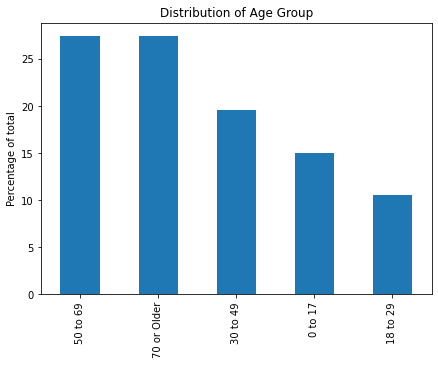

In [18]:
# age group
plt.subplot()
(train_X["Age Group"].value_counts() / float(len(train_X)) * 100).plot(kind="bar", figsize=(7,5))
plt.title("Distribution of Age Group")
plt.ylabel("Percentage of total")

<AxesSubplot:>

Text(0.5, 1.0, 'Distribution of Gender')

Text(0, 0.5, 'Percentage of Total')

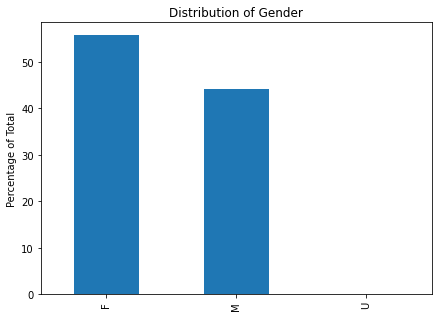

In [19]:
# gender
(train_X["Gender"].value_counts() / float(len(train_X)) * 100).plot(kind="bar", figsize=(7,5))
plt.title("Distribution of Gender")
plt.ylabel("Percentage of Total")

One thing to note - this distribution isn't unexpected. In other data sources that I've worked with (especially Medicare populations) women are represented in higher proportions.

<AxesSubplot:>

Text(0.5, 1.0, 'Distribution of Race')

Text(0, 0.5, 'Percentage of Total')

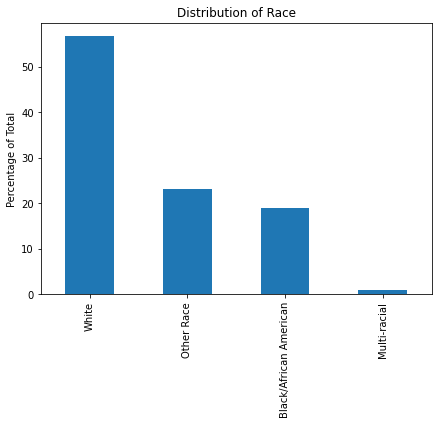

In [20]:
# race
(train_X["Race"].value_counts() / float(len(train_X)) * 100).plot(kind="bar", figsize=(7,5))
plt.title("Distribution of Race")
plt.ylabel("Percentage of Total")

Again, this also isn't surprising. For the sake of time, I will restrict myself to one more distribution - payment method. That will tell me a great deal about the general characteristics of the population.

<AxesSubplot:>

Text(0.5, 1.0, 'Distribution of Primary Payment')

Text(0, 0.5, 'Percentage of Total')

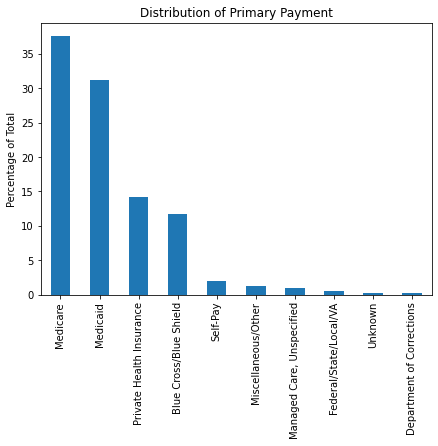

In [21]:
# Primary Payer
(train_X["Payment Typology 1"].value_counts() / float(len(train_X)) * 100).plot(kind="bar", figsize=(7,5))
plt.title("Distribution of Primary Payment")
plt.ylabel("Percentage of Total")

As I suspected - we have a high Medicare percentage here. This jives with the other graphs I have made so far - the M/F ratio is what I would expect from that type of population, as is the age distribution. Now that we have a general sense of the population we are working with, let's see how these variables compare with our target. We will start by correlating our numerical columns with the target.

In [22]:
pd.concat([train_X[["Length of Stay", "Birth Weight"]], train_y], axis=1).corr()

,Length of Stay,Birth Weight,Total Costs
Length of Stay,1.000000,-0.094144,0.715689
Birth Weight,-0.094144,1.000000,-0.116876
Total Costs,0.715689,-0.116876,1.000000


Length of stay seems to have a high correlation with our target - that makes a lot of sense (the longer you are at the hospital, the higher the bill would be expected to be). I anticipate that will be a useful column later on. For our categorical variables, we can use a one-way ANOVA to see if different categorical groups have statistically significantly different means. This will give us a sense of how much information is gained through each column, and with the F score we can get a measure of the information gained. Before we do, we should check normality:

<AxesSubplot:ylabel='Frequency'>

Text(0.5, 0, 'Total Cost')

Text(0.5, 1.0, 'Histogram of Total Costs in the Training Set')

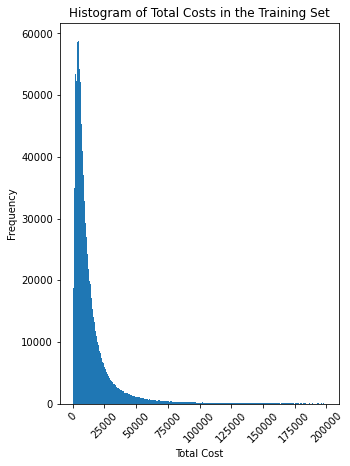

In [61]:
train_y[train_y < 200000].plot(kind="hist", bins=500, figsize=(5, 7), rot=45)
plt.xlabel("Total Cost")
plt.title("Histogram of Total Costs in the Training Set")

Not perfect, but it's relatively close. We should be able to proceed.

In [24]:
# age as an example
groups = [group["Total Costs"].values for name, group in pd.concat([train_X, train_y], axis=1).groupby("Age Group")]
f_oneway(*groups)

F_onewayResult(statistic=8340.392568516096, pvalue=0.0)

In [25]:
for cat in category_list:
    groups = [group["Total Costs"].values for name, group in pd.concat([train_X, train_y], axis=1).groupby(cat)]
    F, p = f_oneway(*groups)
    print(f"{cat}: {F} (pvalue={p})")

Age Group: 8340.392568516096 (pvalue=0.0)
Gender: 1894.125142759522 (pvalue=0.0)
Race: 690.3594050543649 (pvalue=0.0)
Ethnicity: 326.53894015376994 (pvalue=5.397378670939709e-212)
Type of Admission: 4646.453731766769 (pvalue=0.0)
Patient Disposition: 7069.411600311117 (pvalue=0.0)
CCS Diagnosis Code: 661.4207693443934 (pvalue=0.0)
CCS Procedure Code: 2057.038261839185 (pvalue=0.0)
APR DRG Code: 2735.171431920721 (pvalue=0.0)
APR MDC Code: 3214.72350791438 (pvalue=0.0)
APR Severity of Illness Code: 77390.7319836627 (pvalue=0.0)
APR Risk of Mortality: 54347.28921651255 (pvalue=0.0)
APR Medical Surgical Description: 53210.494336425116 (pvalue=0.0)
Payment Typology 1: 1748.004942168572 (pvalue=0.0)
Payment Typology 2: 1380.1573835664065 (pvalue=0.0)
Payment Typology 3: 697.8026512735664 (pvalue=0.0)
Emergency Department Indicator: 86.56744568082017 (pvalue=1.351899739014773e-20)


A couple of observations we can make here:
 * Risk of Mortality, Illness Severity, and Med/Surg appear to be the most important. Mortality and Illness severity are likely proxies of the same thing, so both of them being high is to be expected.
 * Race, Ethnicity, CCS Diagnosis, Payment types 2 and 3, and EDI appear to be uninformative for stratification. CCS Diagnosis is really the only interesting one there - I expected that to have some predictive power due to it describing the state of the patient and the type of services that might have been provided.
 
With that out of the way, the last thing I want to check is the collinearity of a few of these problems - I have a feeling that a few of these features are proxies for eachother. We will start by computing a crosstab, then we can use a chi squared contingency test and Cramer's V to examine the correlation.

In [26]:
# expected low correlation
ct = pd.crosstab(index=train_X["Age Group"], columns=train_X["Race"])
chi2 = chi2_contingency(ct)[0]
mindim = min(ct.shape) - 1
cramers_v = np.sqrt((chi2/len(train_X)) / mindim)
cramers_v

0.11932896850409067

In [27]:
# I would expect slightly higher
ct = pd.crosstab(index=train_X["Ethnicity"], columns=train_X["Race"])
chi2 = chi2_contingency(ct)[0]
mindim = min(ct.shape) - 1
cramers_v = np.sqrt((chi2/len(train_X)) / mindim)
cramers_v

0.25424615019164

In [28]:
# as I suspected - much more highly correlated
ct = pd.crosstab(index=train_X["APR Risk of Mortality"], columns=train_X["APR Severity of Illness Code"])
chi2 = chi2_contingency(ct)[0]
mindim = min(ct.shape) - 1
cramers_v = np.sqrt((chi2/len(train_X)) / mindim)
cramers_v

0.7041907348700145

I expected Risk of Mortality and Severity of Illness to be correlated - if I was performing the modeling, I would likely want to remove one or the other to avoid collinearity. However, I'm going to use H2O's AutoML to speed up finding the model. 

## Modeling
We are going to use H2O's AutoML to run some models. It's surprisingly easy - I actually over complicated it at first by doing my own OHE. Turns out AutoML does it for you, and all you need to do is pass it the data. This was the first time I've tried it, but I will be using this in the future. My only complaint is that running it locally gobbles up every resource my (somewhat high end) PC can throw at it.

In [65]:
aml = H2OAutoML(max_models = 15, seed = 42, verbosity = "info", include_algos = ["GLM", "GBM", "StackedEnsemble"])
aml.train(y=train_y.name, training_frame = h2o.H2OFrame(pd.concat([train_X, train_y], axis=1)))


20:07:36.155: Project: AutoML_20210215_200736153
20:07:36.156: Setting stopping tolerance adaptively based on the training frame: 0.001
20:07:36.156: Build control seed: 42
20:07:36.156: training frame: Frame key: automl_training_Key_Frame__upload_a17990dfd750beb5f9a1ddfa87c24866.hex    cols: 20    rows: 1877544  chunks: 77    size: 45389335  checksum: 2348831737609739032
20:07:36.156: validation frame: NULL
20:07:36.157: leaderboard frame: NULL
20:07:36.157: blending frame: NULL
20:07:36.157: response column: Total Costs
20:07:36.157: fold column: null
20:07:36.157: weights column: null
20:07:36.170: Loading execution steps: [{XGBoost : defaults}, {GLM : defaults}, {DRF : [def_1]}, {GBM : defaults}, {DeepLearning : defaults}, {DRF : [XRT]}, {XGBoost : grids}, {GBM : grids}, {DeepLearning : grids}, {GBM : [lr_annealing]}, {XGBoost : [lr_search]}, {StackedEnsemble : defaults}]
20:07:36.181: Disabling Algo: DeepLearning as requested by the user.
20:07:36.181: Disabling Algo: XGBoost as 

In [66]:
h2o.as_list(h2o.automl.get_leaderboard(aml)).to_csv("leaderboard.csv")

In [67]:
test_preds = aml.leader.predict(h2o.H2OFrame(test_X[feature_list]))

In [74]:
print(f"R2: {r2_score(test_y, h2o.as_list(test_preds))}")
print(f"Explained Variance: {explained_variance_score(test_y, h2o.as_list(test_preds))}")
print(f"RMSE: {mean_squared_error(test_y, h2o.as_list(test_preds), squared=False)}")
print(f"MAE: {mean_absolute_error(test_y, h2o.as_list(test_preds))}")

R2: 0.7771107583858676
Explained Variance: 0.7771111722174998
RMSE: 13084.502196306039
MAE: 4440.284568612631


# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,mean_residual_deviance,rmse,mse,mae,rmsle,training_time_ms,predict_time_per_row_ms
StackedEnsemble_AllModels_AutoML_20210215_200736,1.80643e+08,13440.3,1.80643e+08,4460.73,nan,6782,0.141362
GBM_5_AutoML_20210215_200736,1.84633e+08,13588,1.84633e+08,4450.18,nan,140880,0.022692
StackedEnsemble_BestOfFamily_AutoML_20210215_200736,1.84744e+08,13592.1,1.84744e+08,4450.67,nan,3420,0.015989
GBM_grid__1_AutoML_20210215_200736_model_9,1.84827e+08,13595.1,1.84827e+08,4626.59,nan,95412,0.019888
GBM_2_AutoML_20210215_200736,1.87263e+08,13684.4,1.87263e+08,4625.43,nan,92332,0.015137
GBM_grid__1_AutoML_20210215_200736_model_6,1.87713e+08,13700.9,1.87713e+08,4655.46,nan,93632,0.017741
GBM_grid__1_AutoML_20210215_200736_model_1,1.88168e+08,13717.4,1.88168e+08,4523.47,nan,58814,0.00944
GBM_3_AutoML_20210215_200736,1.88306e+08,13722.4,1.88306e+08,4610.23,nan,83731,0.012677
GBM_1_AutoML_20210215_200736,1.88476e+08,13728.6,1.88476e+08,4671.66,nan,91384,0.015573
GBM_4_AutoML_20210215_200736,1.88681e+08,13736.1,1.88681e+08,4511.6,nan,89499,0.012296


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

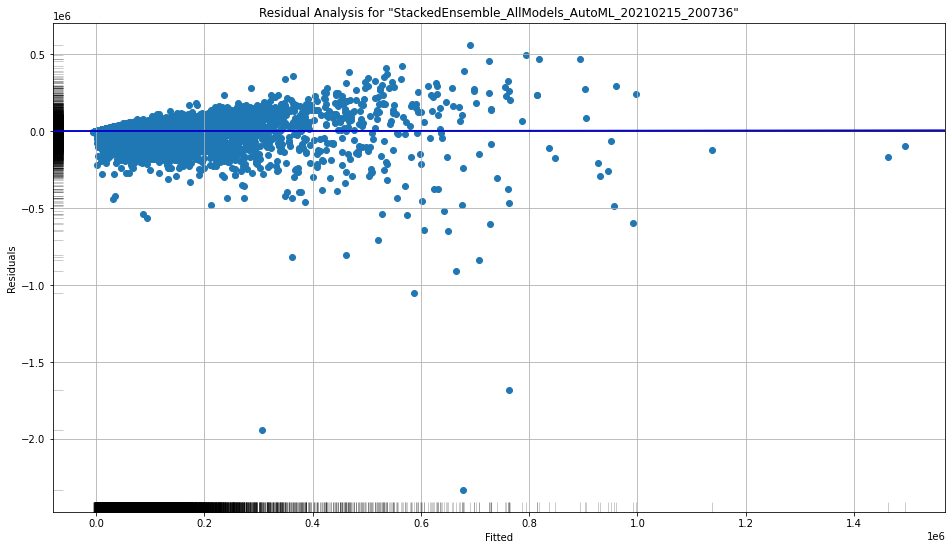

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

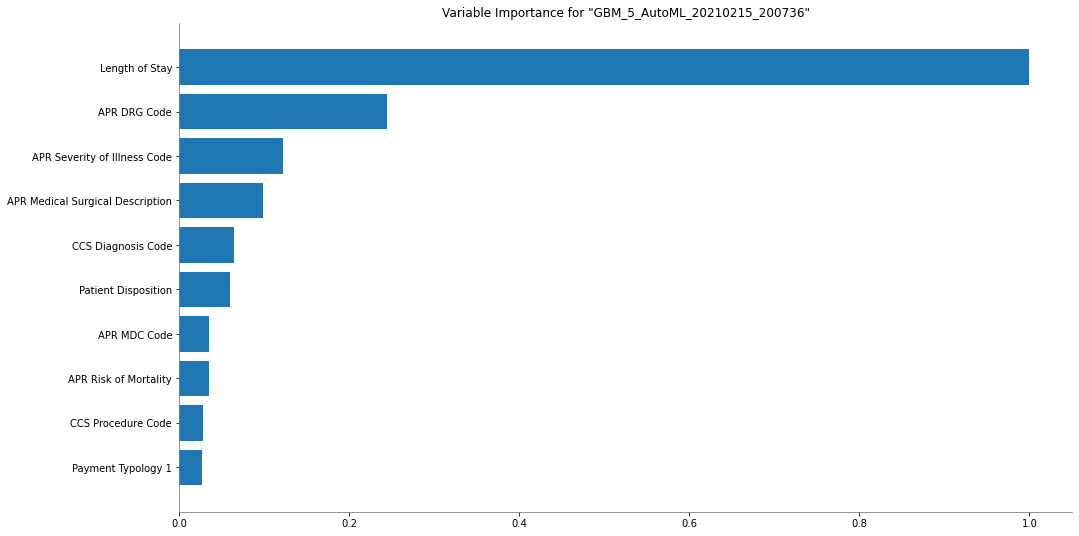

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

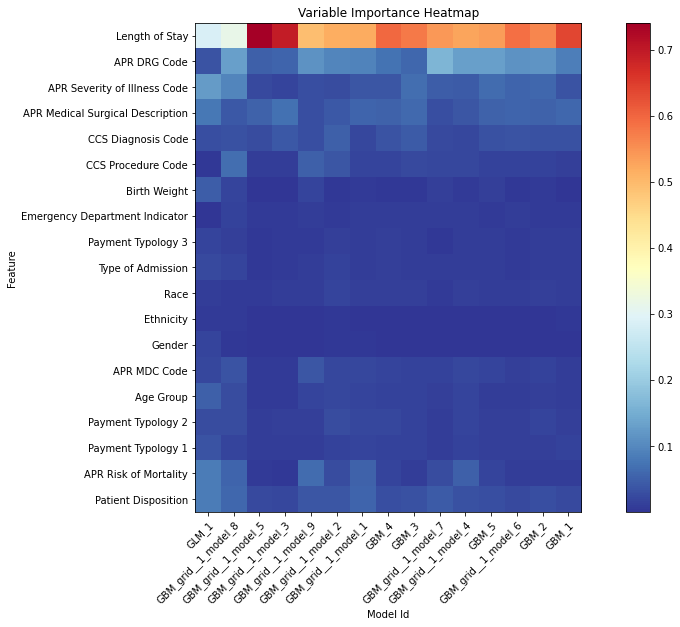

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

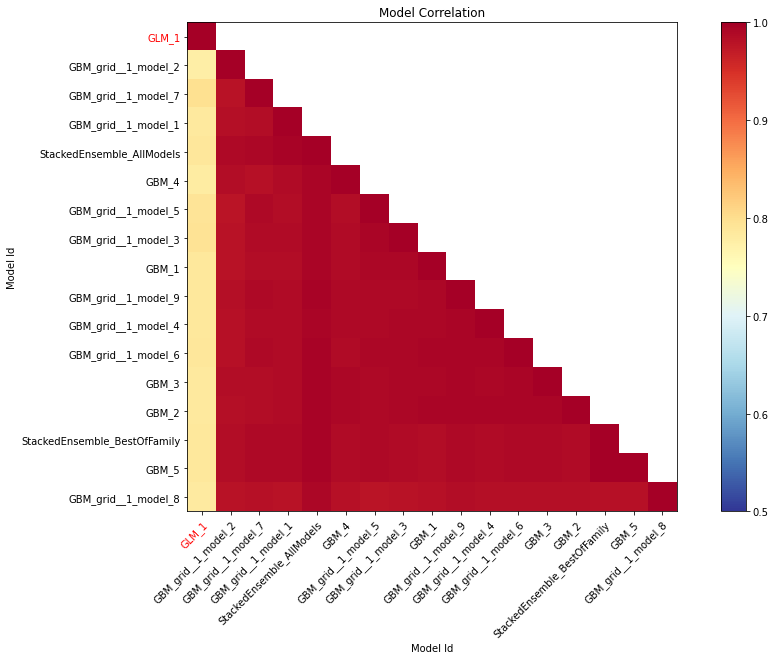

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

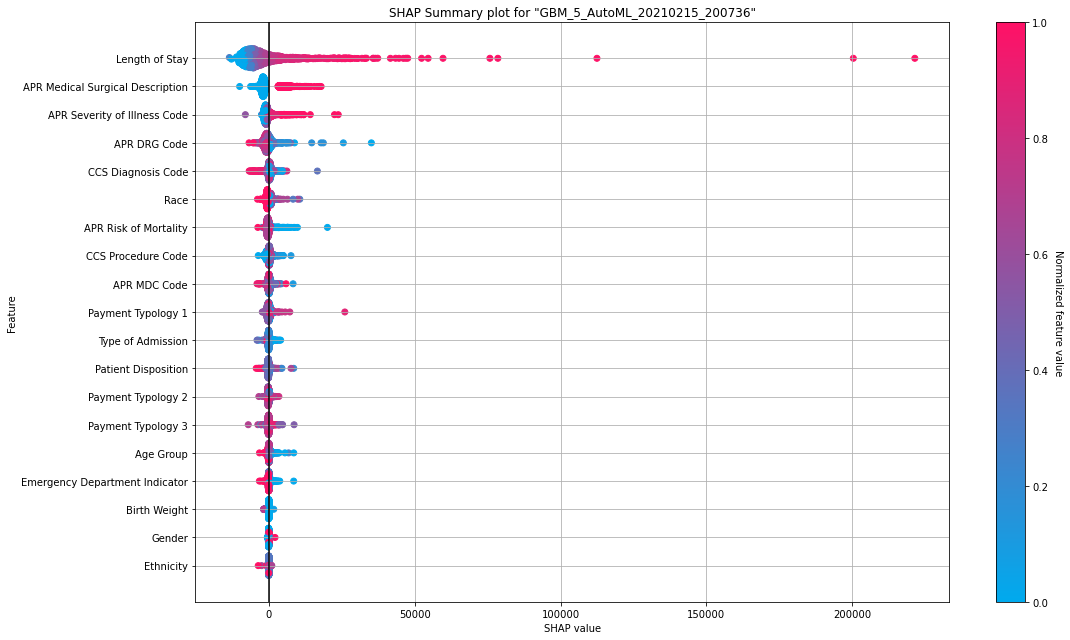

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

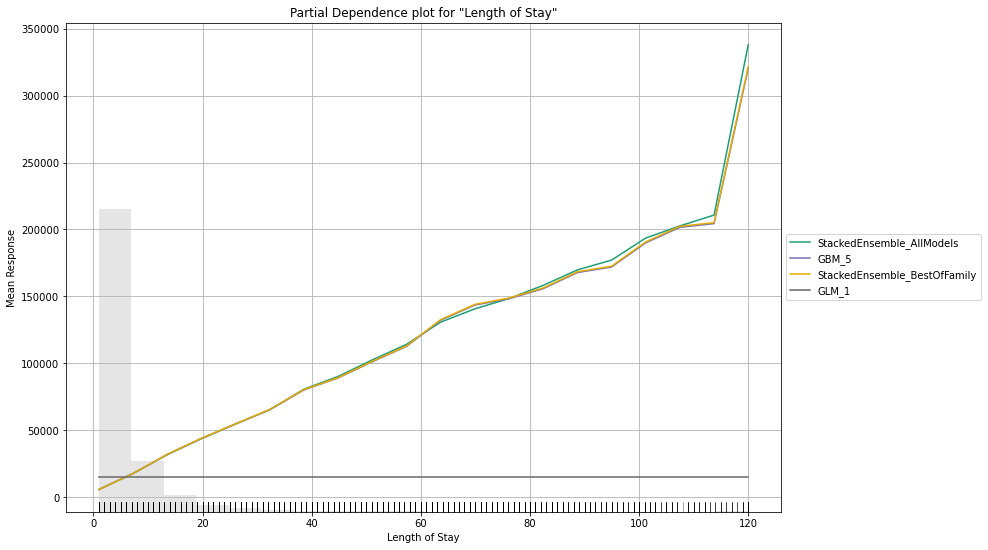

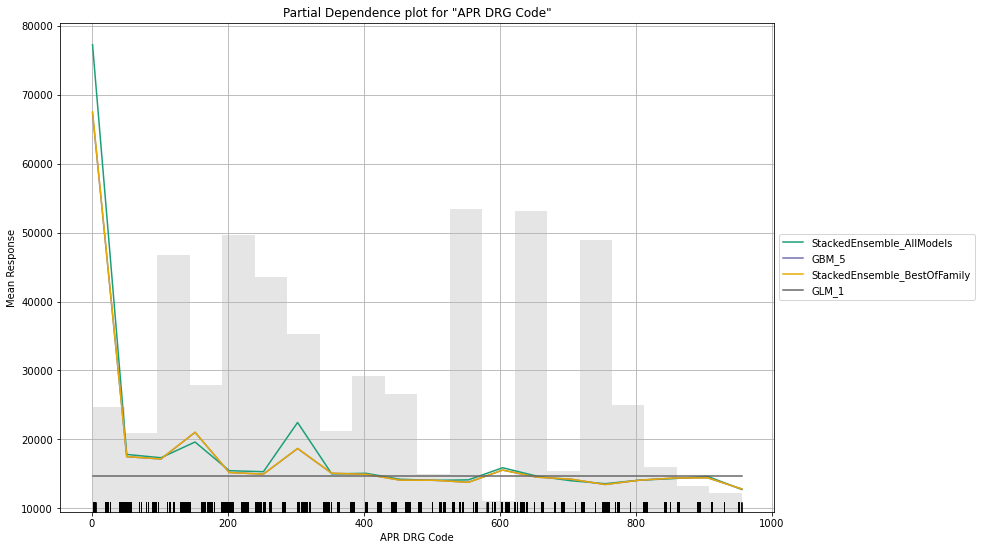

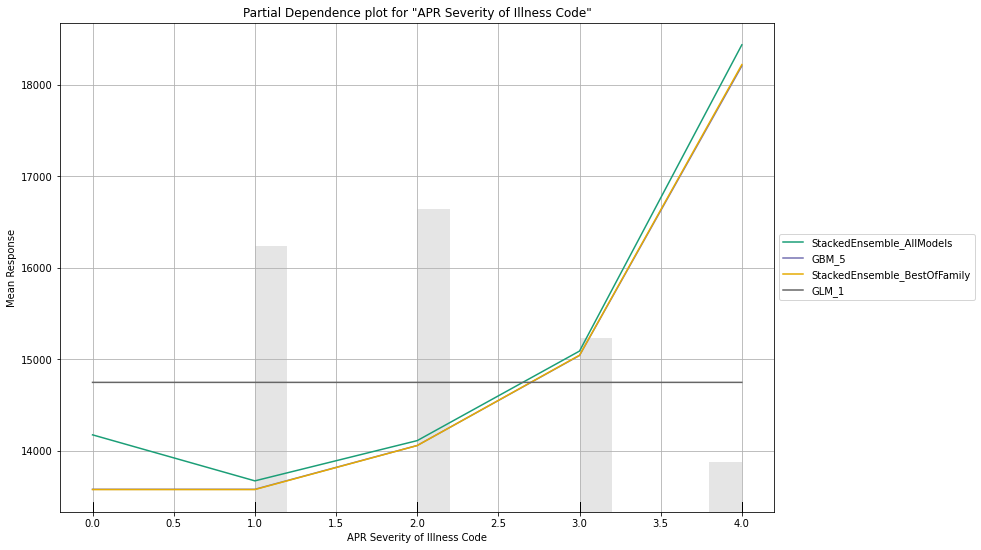

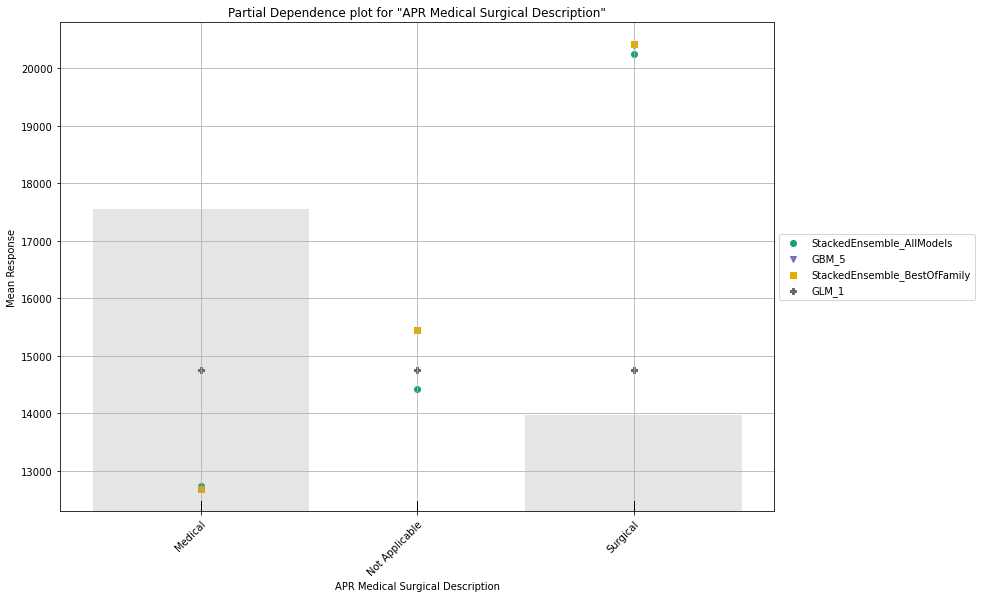

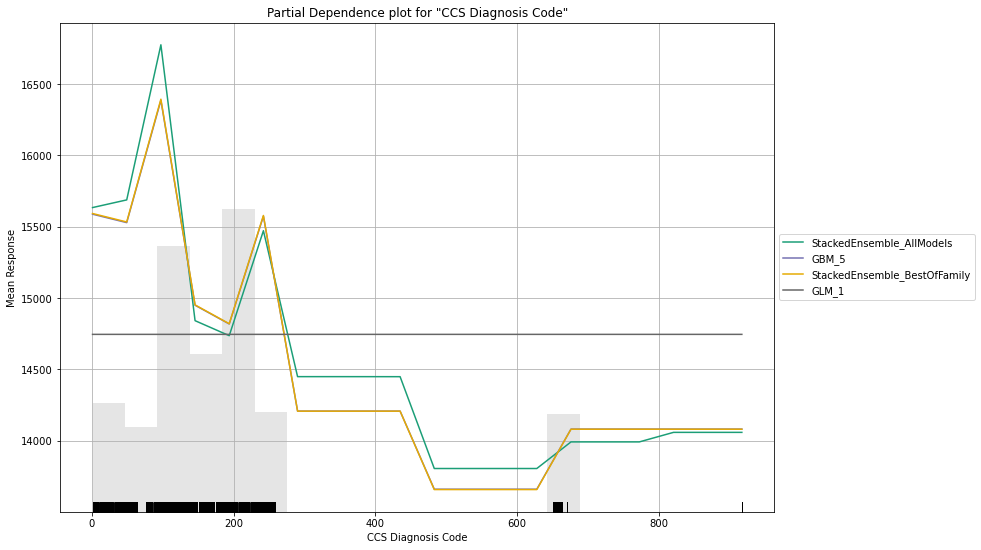

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

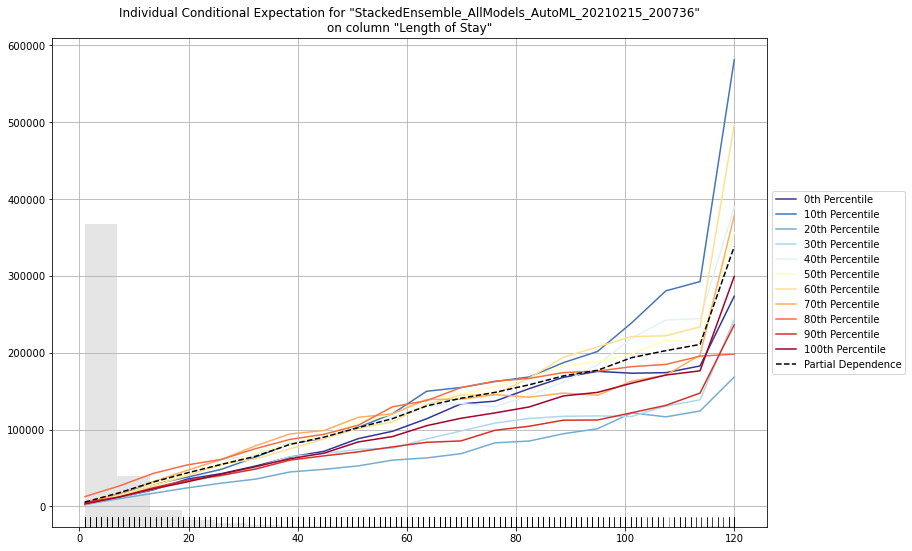

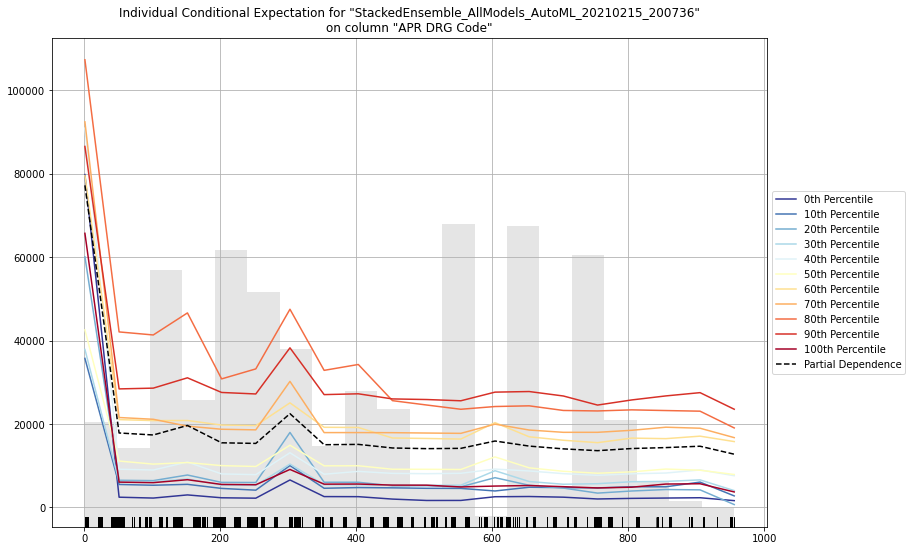

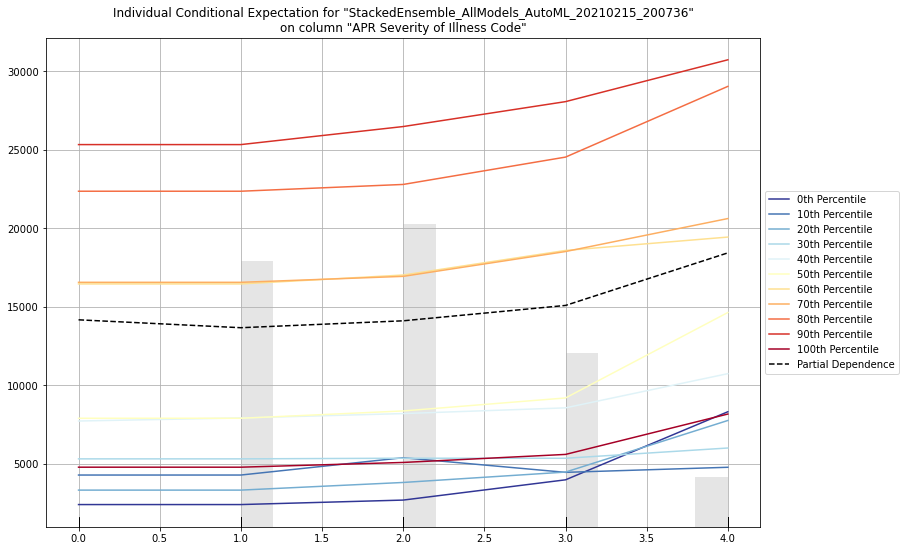

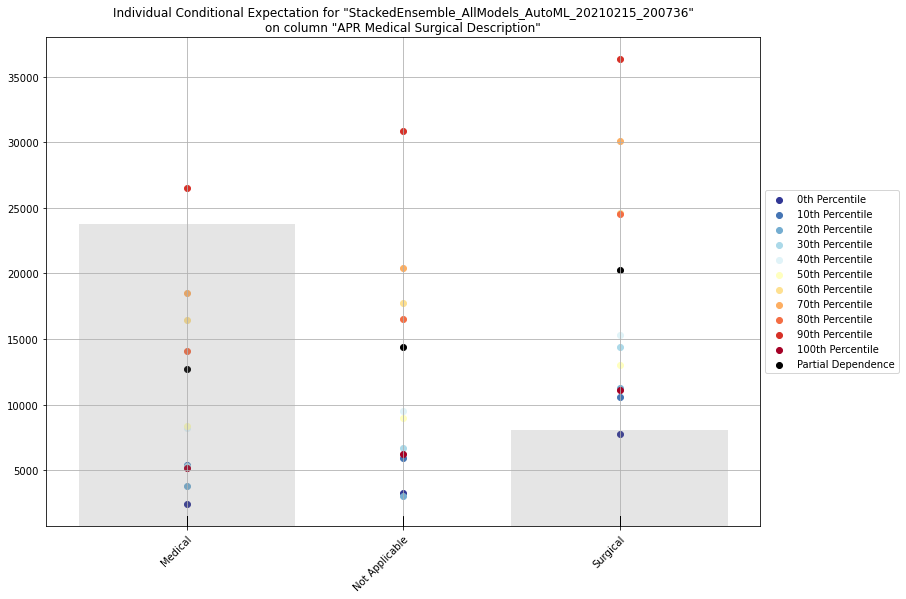

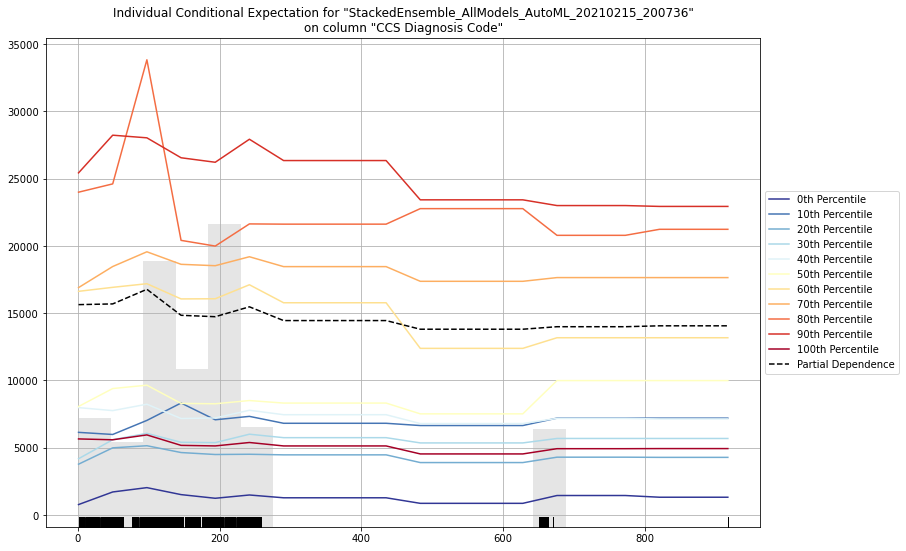

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,mean_residual_deviance,rmse,mse,mae,rmsle,training_time_ms,predict_time_per_row_ms
StackedEnsemble_AllModels_AutoML_20210215_200736,1.80643e+08,13440.3,1.80643e+08,4460.73,nan,6782,0.141362
GBM_5_AutoML_20210215_200736,1.84633e+08,13588,1.84633e+08,4450.18,nan,140880,0.022692
StackedEnsemble_BestOfFamily_AutoML_20210215_200736,1.84744e+08,13592.1,1.84744e+08,4450.67,nan,3420,0.015989
GBM_grid__1_AutoML_20210215_200736_model_9,1.84827e+08,13595.1,1.84827e+08,4626.59,nan,95412,0.019888
GBM_2_AutoML_20210215_200736,1.87263e+08,13684.4,1.87263e+08,4625.43,nan,92332,0.015137
GBM_grid__1_AutoML_20210215_200736_model_6,1.87713e+08,13700.9,1.87713e+08,4655.46,nan,93632,0.017741
GBM_grid__1_AutoML_20210215_200736_model_1,1.88168e+08,13717.4,1.88168e+08,4523.47,nan,58814,0.00944
GBM_3_AutoML_20210215_200736,1.88306e+08,13722.4,1.88306e+08,4610.23,nan,83731,0.012677
GBM_1_AutoML_20210215_200736,1.88476e+08,13728.6,1.88476e+08,4671.66,nan,91384,0.015573
GBM_4_AutoML_20210215_200736,1.88681e+08,13736.1,1.88681e+08,4511.6,nan,89499,0.012296


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

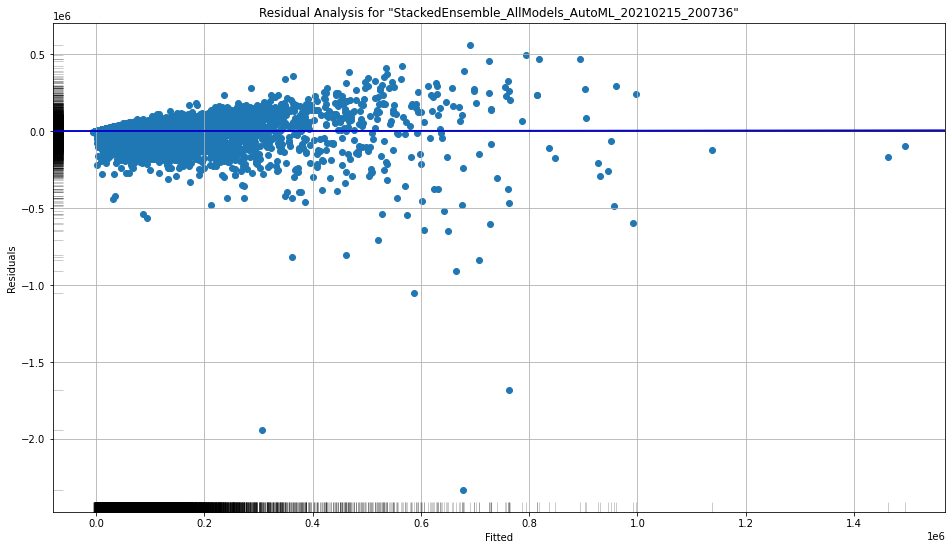

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

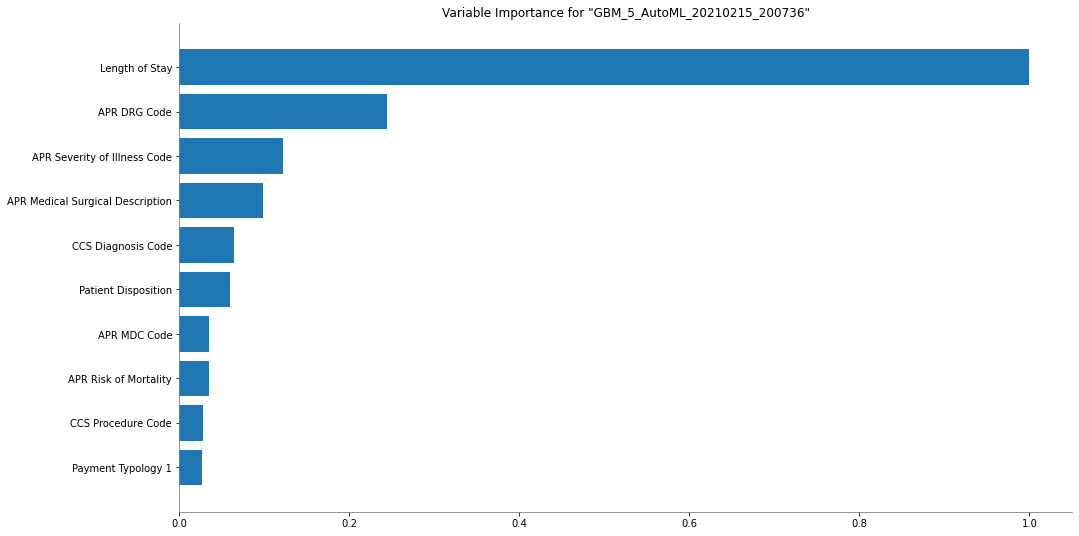

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

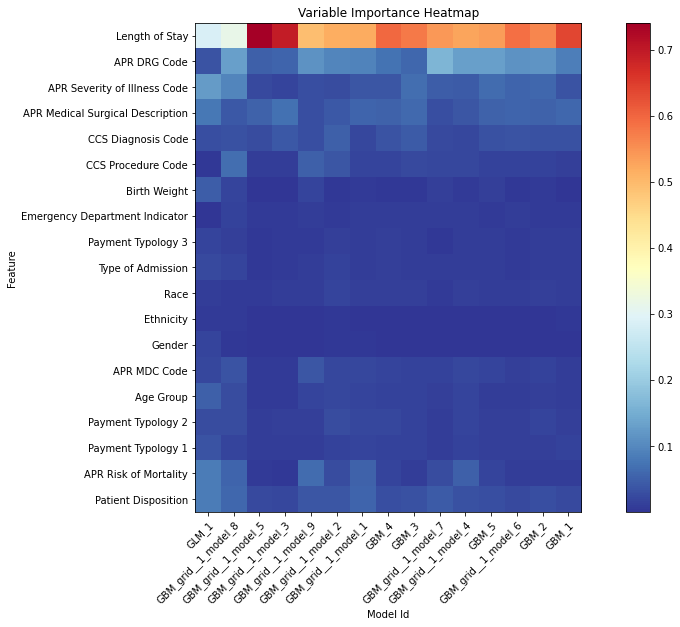

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

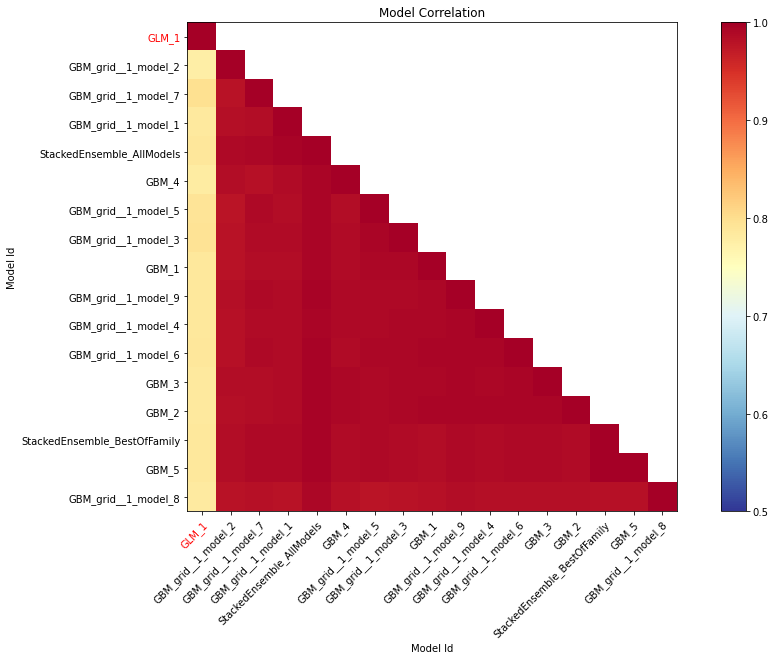

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

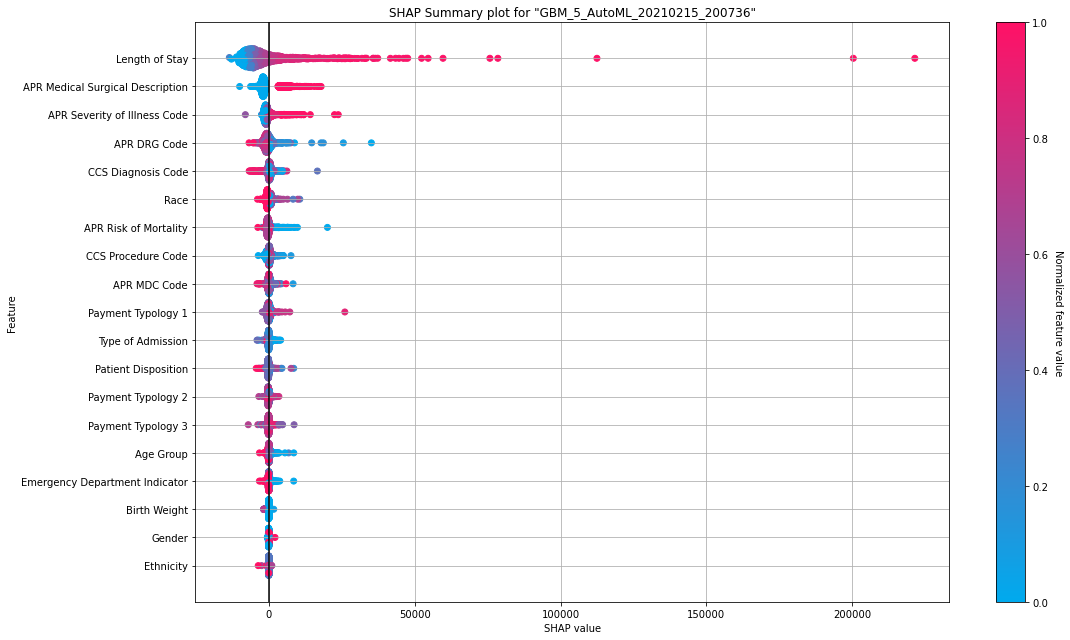

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

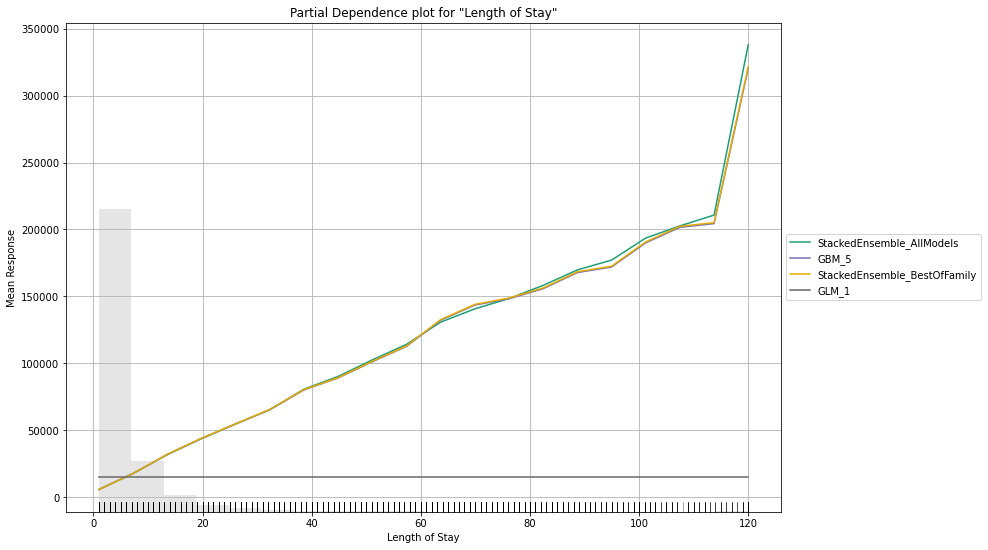

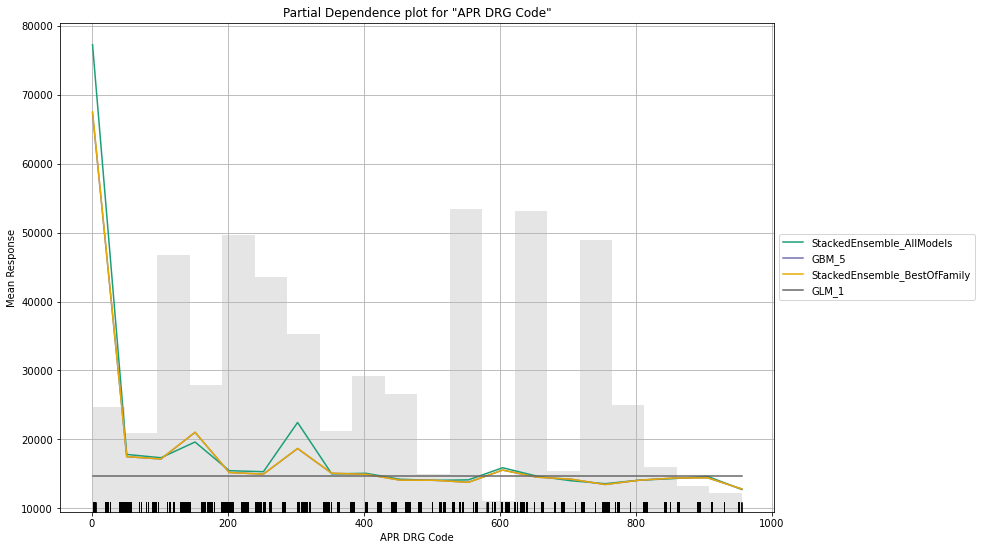

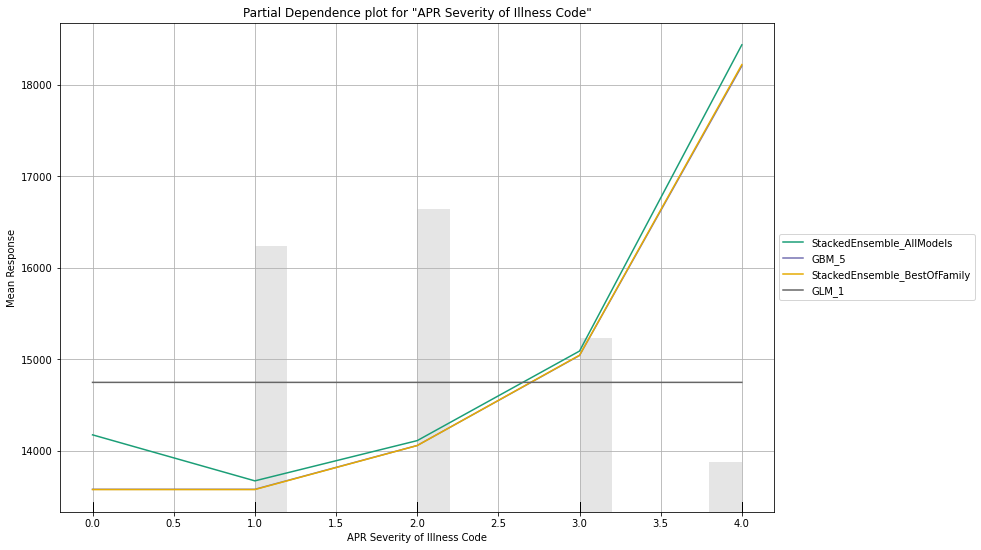

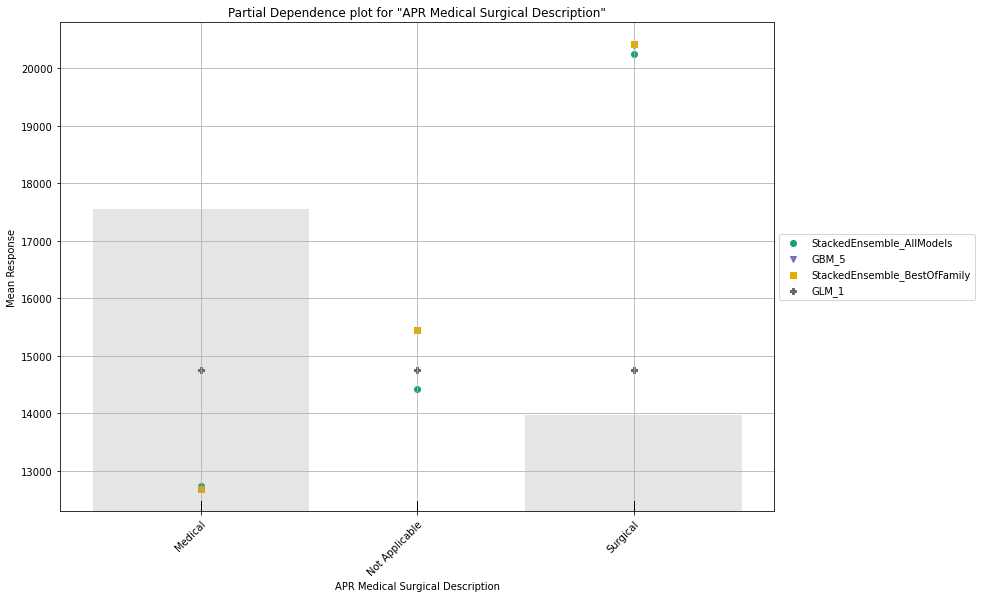

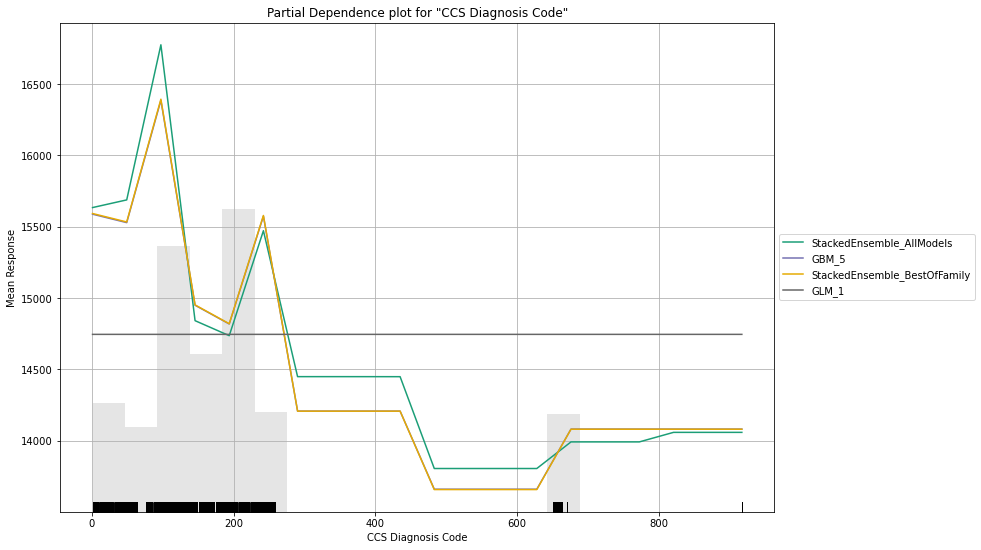

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

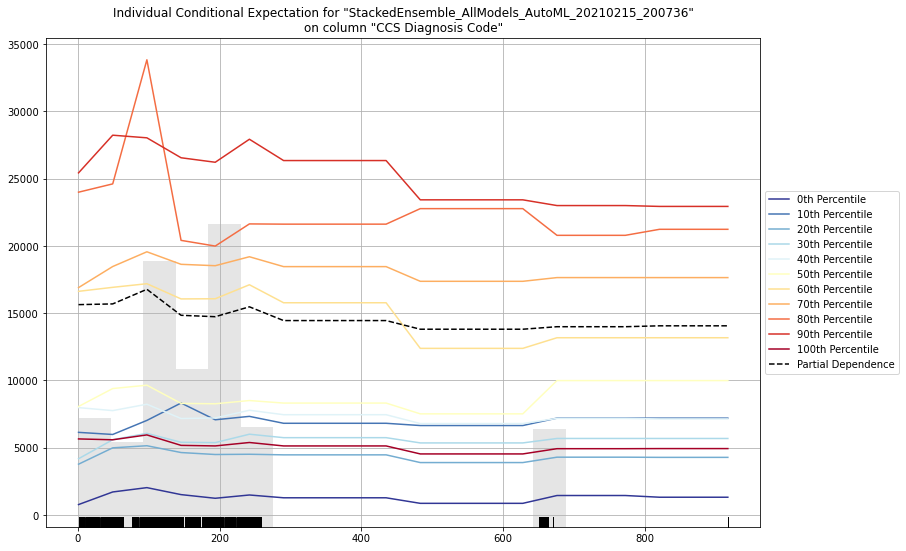

In [69]:
aml.explain(h2o.H2OFrame(pd.concat([test_X[feature_list], test_y], axis=1)))